# LSTM V2 with time series

## 시계열 분석


### 시계열 데이터

- 일정기간 동안 수집된 순차적 데이터 셋의 집합.
- 시간의 흐름에 따라 순서대로 관측되어 시간의 영향을 받게 되는 데이터 ex) 일별, 월별, 분기별, 년도별 ..
  - 이렇게 순차적으로 발생한 연속적인 관측치는 서로 상관관계를 맺고 있음

### 시계열 데이터 분석의 목적

- 미래의 값을 예측하기 위함.
- 시계열이 갖고 있는 법칙성을 발견해 이를 모형화하고 추정된 모형을 통해 미래의 값을 예측하기 위해 분석.

### 시계열 데이터 예시

- 쇼핑몰 구매 데이터
- 소비자 물가 지수
- 일일 주식 트렌드
- 월별/ 분기별/ 연도별 특정 사건의 수치

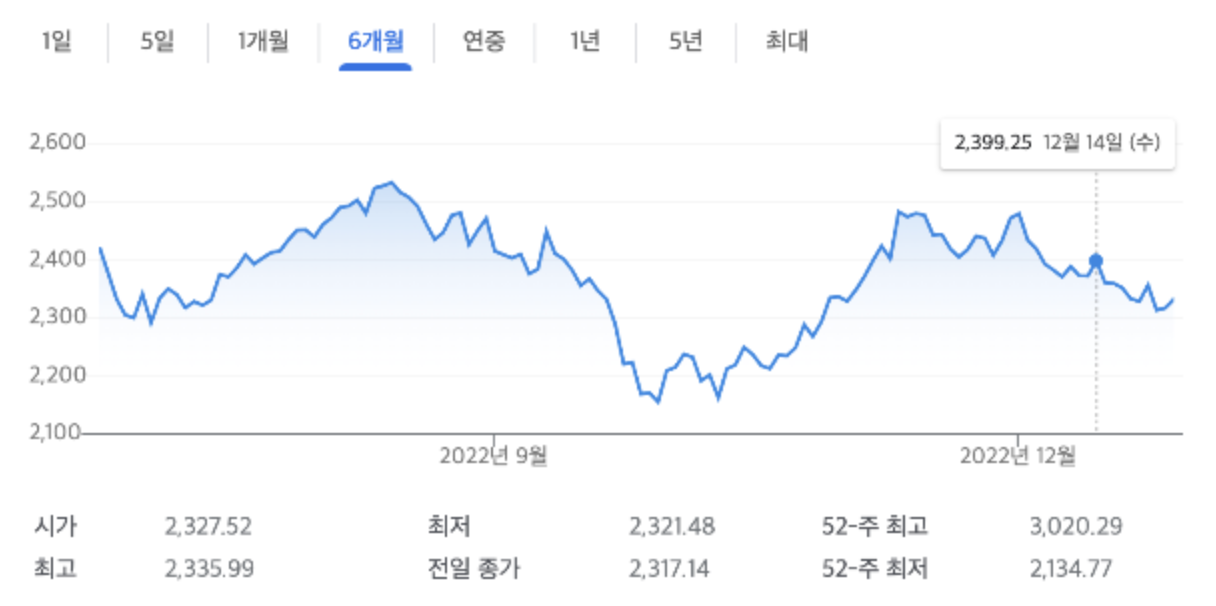

In [1]:
from tqdm.auto import tqdm
import random
import os

import torch

import pandas as pd
import numpy as np
import pandas_datareader.data as web

In [2]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

reset_seeds()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Data

### Load Data

In [4]:
import FinanceDataReader as fdr

In [5]:
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,77800,2,-200,-0.26,77700,78200,77500,10409304,810413065100,464449082390000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,140800,1,400,0.28,140900,141500,139500,1340440,188107633400,102502732992000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,424000,1,3000,0.71,421500,424500,421000,100878,42661812000,99216000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,754000,1,25000,3.43,729000,760000,727000,97011,72546677000,53665196000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,61800,3,0,0.00,61800,61900,61400,629401,38819058200,50854398060000,822886700,STK


In [6]:
df_kospi = df_krx[df_krx['Market'] == 'KOSPI']
df_kospi

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,77800,2,-200,-0.26,77700,78200,77500,10409304,810413065100,464449082390000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,140800,1,400,0.28,140900,141500,139500,1340440,188107633400,102502732992000,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,424000,1,3000,0.71,421500,424500,421000,100878,42661812000,99216000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,754000,1,25000,3.43,729000,760000,727000,97011,72546677000,53665196000000,71174000,STK
4,005935,KR7005931001,삼성전자우,KOSPI,,61800,3,0,0.00,61800,61900,61400,629401,38819058200,50854398060000,822886700,STK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2770,000227,KR7000222000,유유제약2우B,KOSPI,,12330,1,830,7.22,11760,12400,11650,11594,140594260,4014154800,325560,STK
2771,002785,KR7002781003,진흥기업우B,KOSPI,,4670,3,0,0.00,4630,4670,4605,20,92790,4003208060,857218,STK
2774,001525,KR7001521004,동양우,KOSPI,,6050,1,50,0.83,6130,6130,6050,605,3635530,3737272550,617731,STK
2775,002787,KR7002782001,진흥기업2우B,KOSPI,,12480,3,0,0.00,12700,12750,12480,84,1070060,3679203840,294808,STK


In [7]:
def item_code_by_item_name(item_name):
    """
    종목명을 받아 종목코드를 찾아 반환하는 함수
    """
    item_code_list = df_kospi.loc[df_kospi["Name"] == item_name, "Code"].tolist()
    if len(item_code_list) > 0:
        item_code = item_code_list[0]
        return item_code
    else:
        return "없는 주식입니다 !"

In [8]:
def find_item_list(item_name, year=2023):
    """
    종목명을 넘겨주면 일별시세를 반환하는 함수
    내부에서 종목명으로 종목코드를 반환하는 함수(item_code_by_item_name)로
    종목의 시세를 수집합니다.
    """

    item_code = item_code_by_item_name(item_name)
    if item_code:
        df_day = fdr.DataReader(item_code, str(year))
        return df_day
    else:
        return False

In [9]:
df = find_item_list("삼성전자", year = 2023)

In [10]:
df.drop(columns = 'Change', inplace =True)

In [11]:
# df = web.DataReader('005930', 'naver', start='2022-01-01', end='2022-12-31')
# df.head()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2023-01-02 to 2023-12-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Open    245 non-null    int64
 1   High    245 non-null    int64
 2   Low     245 non-null    int64
 3   Close   245 non-null    int64
 4   Volume  245 non-null    int64
dtypes: int64(5)
memory usage: 11.5 KB


In [13]:
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2023-01-02 to 2023-12-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Open    245 non-null    int32
 1   High    245 non-null    int32
 2   Low     245 non-null    int32
 3   Close   245 non-null    int32
 4   Volume  245 non-null    int32
dtypes: int32(5)
memory usage: 6.7 KB


### Scaling

In [14]:
data = df.to_numpy()

data.shape

(245, 5)

In [15]:
data

array([[   55500,    56100,    55200,    55500, 10031448],
       [   55400,    56000,    54500,    55400, 13547030],
       [   55700,    58000,    55600,    57800, 20188071],
       ...,
       [   76100,    76700,    75700,    76600, 13164909],
       [   76700,    78000,    76500,    78000, 20651042],
       [   77700,    78200,    77500,    77900, 10848369]])

- minmax scaling

In [16]:
mins = data.min(axis=0)
sizes = data.max(axis=0) - mins

In [17]:
scaled_data = (data - mins) / sizes
scaled_data

array([[0.0044843 , 0.0045045 , 0.03043478, 0.00442478, 0.17389595],
       [0.        , 0.        , 0.        , 0.        , 0.31921842],
       [0.01345291, 0.09009009, 0.04782609, 0.10619469, 0.59373696],
       ...,
       [0.92825112, 0.93243243, 0.92173913, 0.9380531 , 0.3034228 ],
       [0.95515695, 0.99099099, 0.95652174, 1.        , 0.61287465],
       [1.        , 1.        , 1.        , 0.99557522, 0.20766475]])

- 원복

In [18]:
(scaled_data * sizes) + mins

array([[   55500.,    56100.,    55200.,    55500., 10031448.],
       [   55400.,    56000.,    54500.,    55400., 13547030.],
       [   55700.,    58000.,    55600.,    57800., 20188071.],
       ...,
       [   76100.,    76700.,    75700.,    76600., 13164909.],
       [   76700.,    78000.,    76500.,    78000., 20651042.],
       [   77700.,    78200.,    77500.,    77900., 10848369.]])

### [Series Dataset](https://velog.io/@lazy_learner/LSTM-%EC%8B%9C%EA%B3%84%EC%97%B4-%EC%98%88%EC%B8%A1-%EB%AA%A8%EB%93%88-%EB%A7%8C%EB%93%A4%EA%B8%B0-1)

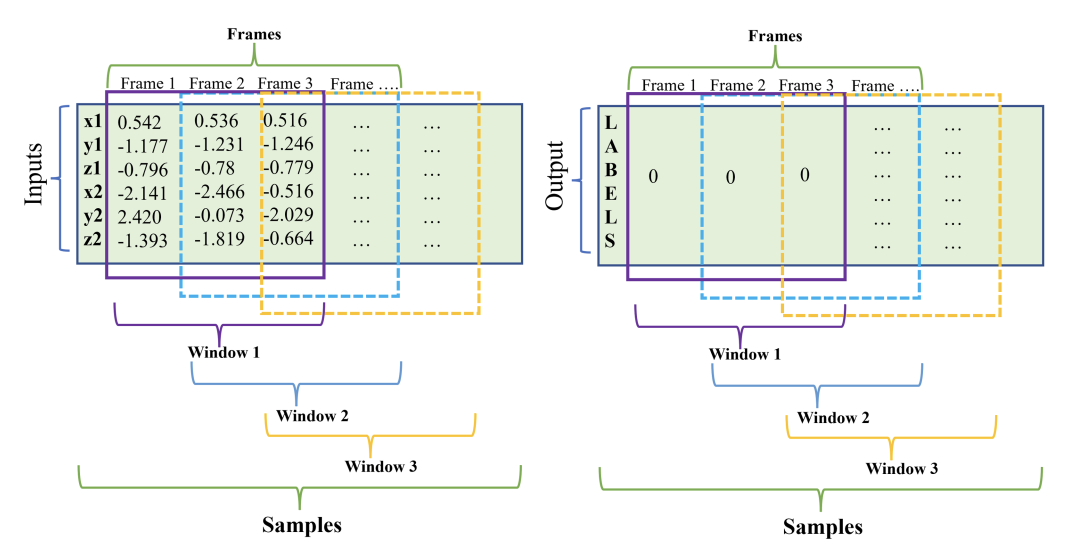

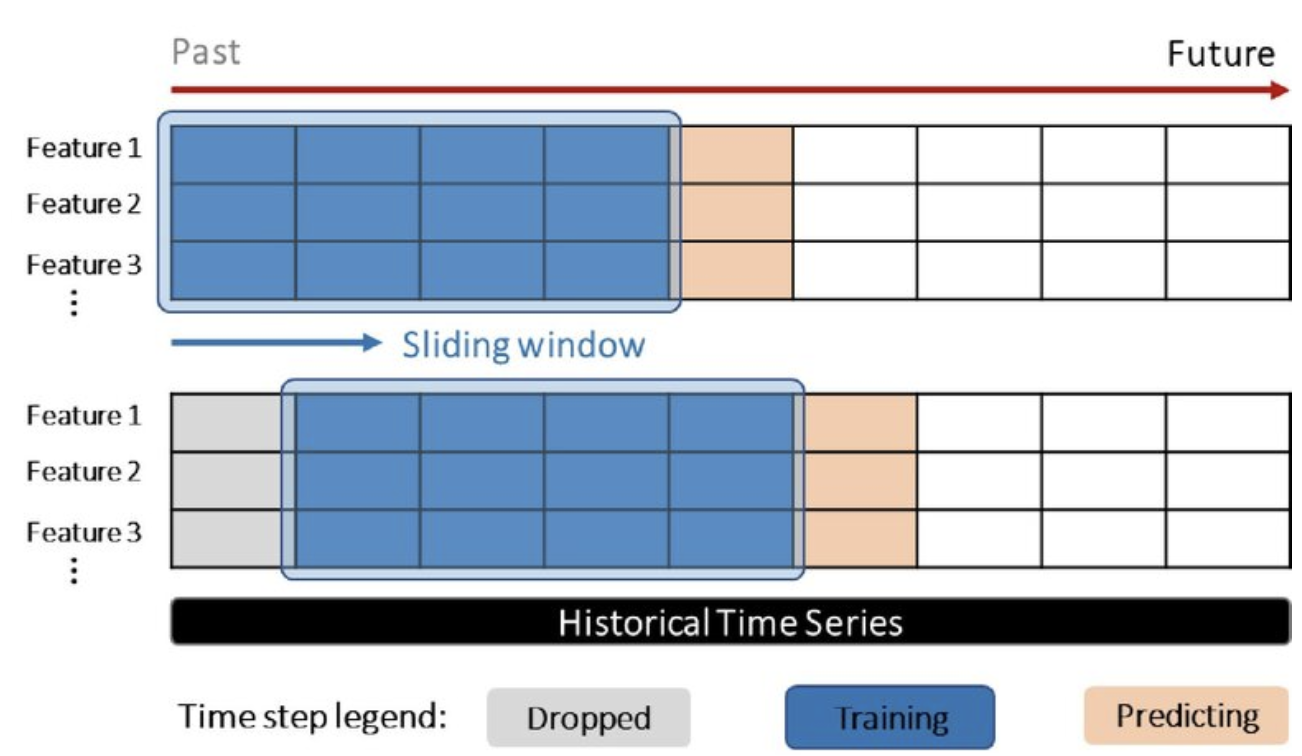

- input_len: 입력길이
- pred_len: 예측길이

In [19]:
def transform_to_series_data(data,mins,sizes,input_len=20,pred_len=14):
    # 스케일링
    data = (data - mins) / sizes

    x_list = []
    y_list = []
    for i in range(input_len, data.shape[0] + 1 - pred_len):
        x = data[i-input_len:i] # 입력데이터 seq(20) , feature(5)
        x_list.append(x)
        y = data[i:i+pred_len, 3] # seq(5)
        y_list.append(y)
    x = np.array(x_list) # batch, seq(10), feature(5)
    y = np.array(y_list) # batch, seq(5)

    return x, y

In [20]:
x_train, y_train = transform_to_series_data(data,mins,sizes)
x_train.shape, y_train.shape

((212, 20, 5), (212, 14))

In [21]:
x_train[0].shape

(20, 5)

In [22]:
y_train[0]

array([0.28318584, 0.35840708, 0.37168142, 0.27433628, 0.28761062,
       0.34070796, 0.33628319, 0.32743363, 0.33185841, 0.34513274,
       0.30088496, 0.36725664, 0.31858407, 0.32300885])

In [23]:
scaled_data[10:15][:,3] # y_train[0]와 같음

array([0.25221239, 0.24778761, 0.22123894, 0.2699115 , 0.28318584])

## Dataset

In [24]:
from torch.utils.data import Dataset

In [25]:
class FinanceDataset(Dataset):
    def __init__(self,x,y):
        self.x = x # batch, seq(10), feature(5)
        self.y = y # batch,seq(6)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self,idx):
        item = {}
        item["x"] = torch.Tensor(self.x[idx])
        item["y"] = torch.Tensor(self.y[idx])
        return item

In [26]:
dt = FinanceDataset(x_train,y_train)

In [27]:
dt[0]

{'x': tensor([[0.0045, 0.0045, 0.0304, 0.0044, 0.1739],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.3192],
         [0.0135, 0.0901, 0.0478, 0.1062, 0.5937],
         [0.1256, 0.1261, 0.1348, 0.1239, 0.4075],
         [0.1300, 0.1532, 0.1478, 0.1593, 0.4758],
         [0.1928, 0.2117, 0.2217, 0.2345, 0.5297],
         [0.2152, 0.2297, 0.2348, 0.2212, 0.3735],
         [0.2511, 0.2342, 0.2522, 0.2257, 0.2681],
         [0.2556, 0.2342, 0.2348, 0.2257, 0.4249],
         [0.2287, 0.2342, 0.2565, 0.2389, 0.2764],
         [0.2646, 0.2523, 0.2739, 0.2522, 0.1742],
         [0.2601, 0.2477, 0.2652, 0.2478, 0.1656],
         [0.2377, 0.2252, 0.2348, 0.2212, 0.2381],
         [0.2287, 0.2477, 0.2565, 0.2699, 0.2887],
         [0.3004, 0.2838, 0.2870, 0.2832, 0.1580],
         [0.3632, 0.3468, 0.3696, 0.3540, 0.4546],
         [0.3767, 0.3559, 0.3826, 0.3761, 0.3081],
         [0.4036, 0.4054, 0.4087, 0.4071, 0.5347],
         [0.4260, 0.4009, 0.3739, 0.3496, 0.6271],
         [0.3632, 0.3468, 

In [28]:
dt[0]['x'].shape, dt[0]['y'].shape

(torch.Size([20, 5]), torch.Size([14]))

## DataLoader

In [29]:
from torch.utils.data import DataLoader

In [30]:
dl = DataLoader(dt, batch_size = 2)

In [31]:
batch = next(iter(dl))
batch

{'x': tensor([[[0.0045, 0.0045, 0.0304, 0.0044, 0.1739],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.3192],
          [0.0135, 0.0901, 0.0478, 0.1062, 0.5937],
          [0.1256, 0.1261, 0.1348, 0.1239, 0.4075],
          [0.1300, 0.1532, 0.1478, 0.1593, 0.4758],
          [0.1928, 0.2117, 0.2217, 0.2345, 0.5297],
          [0.2152, 0.2297, 0.2348, 0.2212, 0.3735],
          [0.2511, 0.2342, 0.2522, 0.2257, 0.2681],
          [0.2556, 0.2342, 0.2348, 0.2257, 0.4249],
          [0.2287, 0.2342, 0.2565, 0.2389, 0.2764],
          [0.2646, 0.2523, 0.2739, 0.2522, 0.1742],
          [0.2601, 0.2477, 0.2652, 0.2478, 0.1656],
          [0.2377, 0.2252, 0.2348, 0.2212, 0.2381],
          [0.2287, 0.2477, 0.2565, 0.2699, 0.2887],
          [0.3004, 0.2838, 0.2870, 0.2832, 0.1580],
          [0.3632, 0.3468, 0.3696, 0.3540, 0.4546],
          [0.3767, 0.3559, 0.3826, 0.3761, 0.3081],
          [0.4036, 0.4054, 0.4087, 0.4071, 0.5347],
          [0.4260, 0.4009, 0.3739, 0.3496, 0.6271],
       

## LSTM Model

In [32]:
import torch.nn as nn

In [33]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, output_size=14, n_hidden=16, num_layers=1, bi_direction=False) -> None:
        super().__init__()
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        self.direction_num = 2 if bi_direction else 1

        self.lstm_layer = nn.LSTM(input_size=input_size, hidden_size=self.n_hidden,
                            num_layers=self.num_layers, bidirectional=bi_direction)
        self.dense_layer = nn.Sequential(
            nn.Linear(self.n_hidden, self.n_hidden//2),
            nn.ReLU(),
            nn.Linear(self.n_hidden//2, output_size)
        )

    def forward(self, x):

        init_hidden = torch.zeros(
            self.num_layers*self.direction_num, x.shape[0], self.n_hidden
        )
        init_cell = torch.zeros(
            self.num_layers*self.direction_num, x.shape[0], self.n_hidden
        )

        out, (hidden_state, cell_state) = self.lstm_layer(x.transpose(1,0), (init_hidden, init_cell))

        predict = self.dense_layer(hidden_state[-1])
        return predict

In [34]:
model = LSTMModel().to(device)
model

LSTMModel(
  (lstm_layer): LSTM(5, 16)
  (dense_layer): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=14, bias=True)
  )
)

In [35]:
batch['x'].shape, batch['y'].shape

(torch.Size([2, 20, 5]), torch.Size([2, 14]))

In [36]:
model(batch['x']).shape

torch.Size([2, 14])

## Engine

### EarlyStopper

In [37]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_loss = np.inf
        self.save_path = save_path

    def is_continuable(self, model, loss):
        if loss < self.best_loss:
            self.best_loss = loss
            self.trial_counter = 0 # 초기화
            torch.save(model, self.save_path)
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1 # 기존 시도횟수 + 1
            return True
        else:
            return False

### train_loop

In [38]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    epoch_loss = 0
    model.train()
    for batch in dataloader:
        pred = model(batch["x"].to(device))
        loss = loss_fn(pred, batch["y"].to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

### test_loop

In [39]:
@torch.inference_mode()
def test_loop(dataloader,model,loss_fn, device):
    epoch_loss = 0
    model.eval()

    pred_list = []
    for batch in dataloader:
        pred = model(batch["x"].to(device))

        if batch.get("y") is not None:
            loss = loss_fn(pred, batch["y"].to(device))
            epoch_loss += loss.item()

        _pred = pred.to("cpu").numpy()
        pred_list.append(_pred)

    epoch_loss /= len(dataloader)

    pred = np.concatenate(pred_list)
    return epoch_loss, pred

## Training

In [40]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold

- Hyper Parameters

In [41]:
input_size_enc = x_train.shape[2]
input_size_dec = 1
hidden_size = 32
is_attention = False

n_splits = 5
batch_size = 32
epochs = 1000
loss_fn = torch.nn.MSELoss()

- cross validation

In [42]:
SEED = 42
cv = KFold(n_splits=n_splits,shuffle=True,random_state=SEED)

In [43]:
reset_seeds(SEED)

best_loss_list = []
for i, (tri,vai) in enumerate(cv.split(x_train)):

    # 학습용
    train_dt = FinanceDataset(x_train[tri], y_train[tri])
    train_dl = DataLoader(train_dt,batch_size=batch_size,shuffle=False)

    # 검증용
    valid_dt = FinanceDataset(x_train[vai], y_train[vai])
    valid_dl = DataLoader(valid_dt,batch_size=batch_size,shuffle=False)

    model = LSTMModel().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    early_stopper = EarlyStopper(num_trials=30, save_path=f'best_model_{i}.pt')

    for epoch in tqdm(range(epochs)):
        train_loop(train_dl, model, loss_fn, optimizer, device)
        valid_loss, pred = test_loop(valid_dl, model, loss_fn, device)

        pred = pred * sizes[3] + mins[3] # 원래의 수치로 복원
        true = y_train[vai] * sizes[3] + mins[3] # 원래의 수치로 복원
        score = mean_absolute_percentage_error(true,pred)

        if not early_stopper.is_continuable(model, valid_loss):
            print(f'Cross Validation:{i} >> best loss: {early_stopper.best_loss}')
            best_loss_list.append(early_stopper.best_loss)
            break


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Cross Validation:1 >> best loss: 0.0028315574163571


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Cross Validation:4 >> best loss: 0.003948968951590359


In [44]:
np.mean(best_loss_list)

0.0033902631839737296

In [45]:
pred.shape

(42, 14)

In [46]:
columns = [ '오늘날짜+1', '오늘날짜+2', '오늘날짜+3', '오늘날짜+4', '오늘날짜+5'
          , '오늘날짜+6', '오늘날짜+7', '오늘날짜+8', '오늘날짜+9', '오늘날짜+10'
          , '오늘날짜+11', '오늘날짜+12', '오늘날짜+13', '오늘날짜+14']
df_pred = pd.DataFrame(pred, columns=columns)
df_pred

,오늘날짜+1,오늘날짜+2,오늘날짜+3,오늘날짜+4,오늘날짜+5,오늘날짜+6,오늘날짜+7,오늘날짜+8,오늘날짜+9,오늘날짜+10,오늘날짜+11,오늘날짜+12,오늘날짜+13,오늘날짜+14
0,62597.695312,64154.882812,62762.648438,63003.585938,62764.562500,62920.734375,63029.589844,63320.695312,63156.828125,64283.902344,63442.515625,64016.542969,63211.789062,63915.539062
1,61606.187500,63370.277344,62095.359375,62036.351562,61692.265625,61933.035156,62348.265625,62568.808594,62316.988281,63366.652344,62368.585938,63182.011719,62251.523438,63092.464844
2,61122.945312,62983.167969,61839.503906,61562.839844,61156.550781,61452.500000,62081.609375,62243.636719,61938.128906,62897.988281,61821.011719,62785.007812,61796.804688,62714.933594
3,61112.261719,62977.031250,61798.164062,61553.453125,61151.445312,61441.441406,62042.066406,62215.210938,61914.082031,62898.746094,61821.335938,62771.226562,61779.910156,62694.437500
4,62071.203125,63659.718750,63564.578125,62454.933594,61976.867188,62410.429688,63758.054688,63609.562500,63218.667969,63436.597656,62469.476562,63735.570312,62923.500000,63872.210938
5,64150.136719,65362.457031,64115.367188,64508.687500,64385.371094,64470.984375,64386.710938,64681.203125,64607.031250,65624.148438,65016.750000,65366.390625,64774.335938,65309.109375
6,64457.910156,65605.093750,64335.941406,64808.519531,64715.687500,64777.742188,64610.878906,64922.597656,64873.632812,65904.679688,65345.425781,65627.320312,65074.988281,65569.179688
7,64773.917969,65851.546875,64601.839844,65115.179688,65047.394531,65093.187500,64878.210938,65193.910156,65164.679688,66180.437500,65669.164062,65900.765625,65391.238281,65849.632812
8,64666.628906,65772.523438,64443.062500,65013.140625,64947.707031,64985.250000,64722.859375,65061.031250,65035.781250,66108.156250,65583.109375,65798.320312,65270.738281,65731.085938
9,65488.453125,66397.007812,65376.625000,65803.312500,65764.664062,65808.578125,65646.335938,65910.671875,65898.984375,66749.898438,66340.718750,66543.390625,66139.593750,66542.859375


In [47]:
df_pred = df_pred.tail(1)
df_pred

,오늘날짜+1,오늘날짜+2,오늘날짜+3,오늘날짜+4,오늘날짜+5,오늘날짜+6,오늘날짜+7,오늘날짜+8,오늘날짜+9,오늘날짜+10,오늘날짜+11,오늘날짜+12,오늘날짜+13,오늘날짜+14
41,72500.6875,71777.898438,72570.296875,72568.851562,72881.09375,72824.179688,72798.03125,72700.820312,72925.289062,72466.03125,73073.90625,72792.476562,73405.140625,73206.46875
